In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_columns', None)
import re
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from scipy.stats import chi2_contingency
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import OneHotEncoder

# 0.Importing from cleaned data notebook


For now, we are working on three files separately. We will work on the regional information, with the count column as a target column. After cleaning we will run a linear regression to attempt to predict number of cases.

Finally, the victims data will be used for some clustering exploration. Similarly, some clustering will be run on the regional demographics.

<br/>
1. We will explore the region information<br/>
- correlation between column <br/>
- distribution <br/>
- outliers 
<br/>
2. Encoding and Standardization <br/>
- standardize data regions <br/>
- encode data victims <br/>
3. Save for clustering and models > new notebook <br/>

In [3]:
victims = pd.read_csv('victims_cleaned.csv')

In [4]:
regions = pd.read_csv('regions_cleaned.csv')

In [5]:
country_death = pd.read_csv('country_femicides.csv')

In [6]:
victims.head()

,Unnamed: 0,age,date,prov_name,perpetrator_en_new,excuses_cat
0,0,18.0,2017-12-31,istanbul,boyfriend,Unknown
1,1,17.0,2017-12-31,burdur,boyfriend,Separation & Jealousy
2,2,38.0,2017-12-30,bolu,boyfriend,Other
3,3,53.0,2017-12-27,ankara,boyfriend,Separation & Jealousy
4,4,22.0,2017-12-25,diyarbakir,partner,Separation & Jealousy


In [7]:
victims = victims.drop('Unnamed: 0', axis =1)

In [8]:
regions.head()

,Unnamed: 0,prov_code,year,all_wm_prov,knows_wm_prov,total_pop,ethnic_turkish,ethnic_kurdish,ln_casualty,ln_gdppc_cons,divorce_rate_ma5,mosques_perk,ceasefire,fm_diff_educ,count,pol_attitude,count_k
0,0,1,2010,20,19,2085225,82.03772,13.370917,3.178054,4.187798,1.458,0.606649,0,-0.062882,20,-29.7,0.009591
1,1,1,2011,15,15,2108805,82.03772,13.370917,3.178054,4.270533,1.532,0.599866,0,-0.068188,15,-29.7,0.007113
2,2,1,2012,9,9,2125635,82.03772,13.370917,3.178054,4.310695,1.632,0.640750,0,-0.067100,9,-29.7,0.004234
3,3,1,2013,7,7,2149260,82.03772,13.370917,3.178054,4.350712,1.712,0.651852,1,-0.066711,7,-33.6,0.003257
4,4,1,2014,14,14,2165595,82.03772,13.370917,3.178054,4.379060,1.790,0.654324,1,-0.067147,14,-33.6,0.006465


In [9]:
regions = regions.drop('Unnamed: 0', axis =1)

We also drop the year, as it is not needed from now on

In [10]:
regions = regions.drop('year', axis =1)

In [11]:
regions.dtypes

prov_code             int64
all_wm_prov           int64
knows_wm_prov         int64
total_pop             int64
ethnic_turkish      float64
ethnic_kurdish      float64
ln_casualty         float64
ln_gdppc_cons       float64
divorce_rate_ma5    float64
mosques_perk        float64
ceasefire             int64
fm_diff_educ        float64
count                 int64
pol_attitude        float64
count_k             float64
dtype: object

# 1. Region Data

#### Splitting numericals and categoricals

Ceasefire would appear to be the only categoricals when checking for 10+ values as min. requirement for numericals.

It takes the value of 1 in years 2013 and 2014, and 0 otherwise. This variable is interacted with Civil War Exposure. Basically it is already encoded and we can keep it in the numericals.

In [12]:
num = regions
num.head()

,prov_code,all_wm_prov,knows_wm_prov,total_pop,ethnic_turkish,ethnic_kurdish,ln_casualty,ln_gdppc_cons,divorce_rate_ma5,mosques_perk,ceasefire,fm_diff_educ,count,pol_attitude,count_k
0,1,20,19,2085225,82.03772,13.370917,3.178054,4.187798,1.458,0.606649,0,-0.062882,20,-29.7,0.009591
1,1,15,15,2108805,82.03772,13.370917,3.178054,4.270533,1.532,0.599866,0,-0.068188,15,-29.7,0.007113
2,1,9,9,2125635,82.03772,13.370917,3.178054,4.310695,1.632,0.640750,0,-0.067100,9,-29.7,0.004234
3,1,7,7,2149260,82.03772,13.370917,3.178054,4.350712,1.712,0.651852,1,-0.066711,7,-33.6,0.003257
4,1,14,14,2165595,82.03772,13.370917,3.178054,4.379060,1.790,0.654324,1,-0.067147,14,-33.6,0.006465


# 1.Exploration on Numericals

In [53]:
for i in num.columns:
    print(num[i].describe())

count    438.000000
mean      39.520548
std       22.900707
min        1.000000
25%       20.000000
50%       39.500000
75%       59.000000
max       81.000000
Name: prov_code, dtype: float64
count    438.000000
mean       4.150685
std        5.340158
min        1.000000
25%        1.000000
50%        2.000000
75%        5.000000
max       46.000000
Name: all_wm_prov, dtype: float64
count    438.000000
mean       3.995434
std        5.133903
min        0.000000
25%        1.000000
50%        2.000000
75%        5.000000
max       42.000000
Name: knows_wm_prov, dtype: float64
count    4.380000e+02
mean     1.177488e+06
std      1.970766e+06
min      8.652700e+04
25%      3.605965e+05
50%      7.117025e+05
75%      1.291487e+06
max      1.502923e+07
Name: total_pop, dtype: float64
count    438.000000
mean      79.283693
std       30.078154
min        0.000000
25%       73.880960
50%       95.491400
75%       99.158850
max      100.000000
Name: ethnic_turkish, dtype: float64
count    438.

#### Make count relative

As we have both the population and the count, we can drop the population and just make the count of femicides cases relative to region's population. Cases per 100k.

In [54]:
list1 = list(num['total_pop'])
list2 = list(num['count'])
#list_values=(set(list1) / set(list2))*100000 
list_values = []

# get last index for the lists for iteration
end_index = len(list1)

for i in range(end_index):
    list_values.append((list2[i]/list1[i])*1000)

In [55]:
num['count_k'] = np.array(list_values)

In [56]:
num = num.drop(['total_pop', 'count'], axis=1)

#### Check Multicollinearity
between features, so we temporarily drop the target variable (count_k)

In [57]:
temp_num = num.drop('count_k', axis=1)

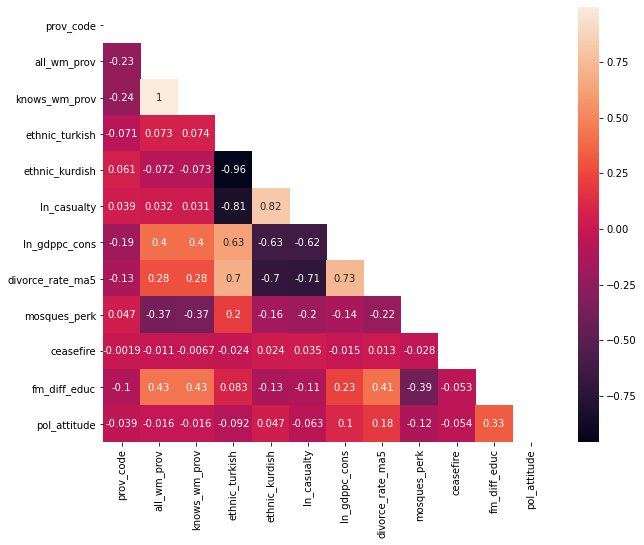

In [58]:
correlations_matrix = temp_num.corr()
mask = np.zeros_like(correlations_matrix)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(correlations_matrix, mask=mask, annot=True)
plt.show()

### Dropping columns

Based on the heatmap, and the fact we have imported the count per region. We drop the columns with information about cases country wide: all_wm_prov and knows_wm_prov
Also, checking for features that have more than 0.80 correlation, we drop:
- ethnic turkish, as it has high correlation with casualty and ethnic kurdish (inverse correlation)
- we can also see that kurdish population and war casualty have a correlation above 80. We will drop casualty and just keep kurdish ethnicity.

In [59]:
num = num.drop(['all_wm_prov', 'knows_wm_prov','ethnic_turkish', 'ln_casualty'], axis = 1)

*Multicollinearity shows generally values above 0.50. It is good to also check the data with VIF.*

In [60]:
vif = {}
num_vif = num.copy()
num_vif= add_constant(num)
for i in np.arange(num_vif.shape[1]):
    column_name = num_vif.columns[i]
    value = variance_inflation_factor(np.array(num_vif), i)
    vif[column_name] = value
vif

{'const': 379.3204445190899,
 'prov_code': 1.1003228768375357,
 'ethnic_kurdish': 2.889708370189312,
 'ln_gdppc_cons': 2.4066788185126318,
 'divorce_rate_ma5': 3.800076741088136,
 'mosques_perk': 1.5298598368490481,
 'ceasefire': 1.0136104826372219,
 'fm_diff_educ': 1.5128452894216984,
 'pol_attitude': 1.1863329413625705,
 'count_k': 1.129494659868797}

In general, a VIF above 10 indicates high correlation and is cause for concern. Thus, we do not drop any column.

### Correlation between numerical variables and target

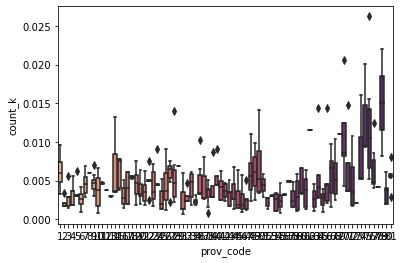

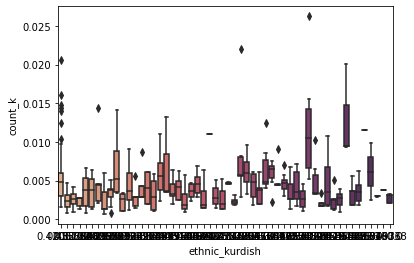

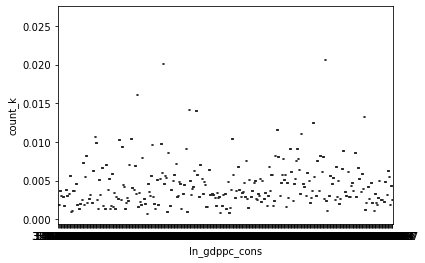

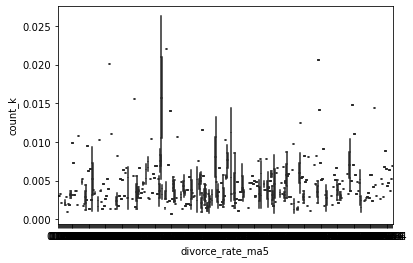

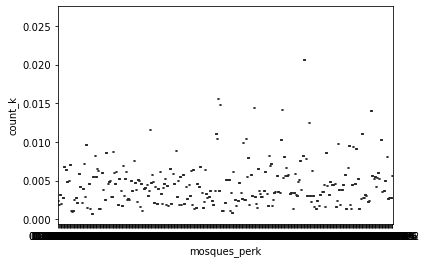

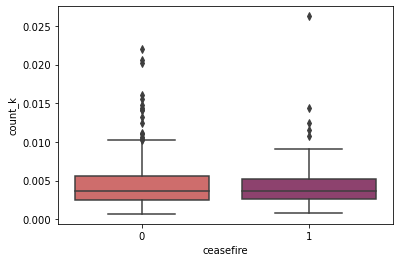

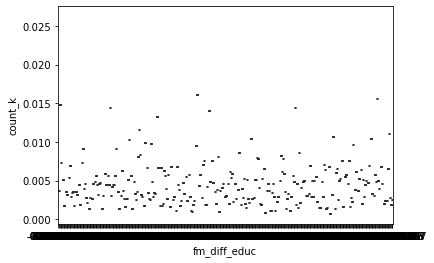

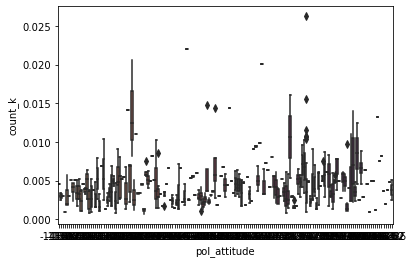

In [61]:
for i in num:
    if i != 'count_k':
        sns.boxplot(x=i, y="count_k", palette='flare', data = num)
        plt.show()
    else:
        continue
#result: here it is possible to see the relationship between q3_balance and the target variable

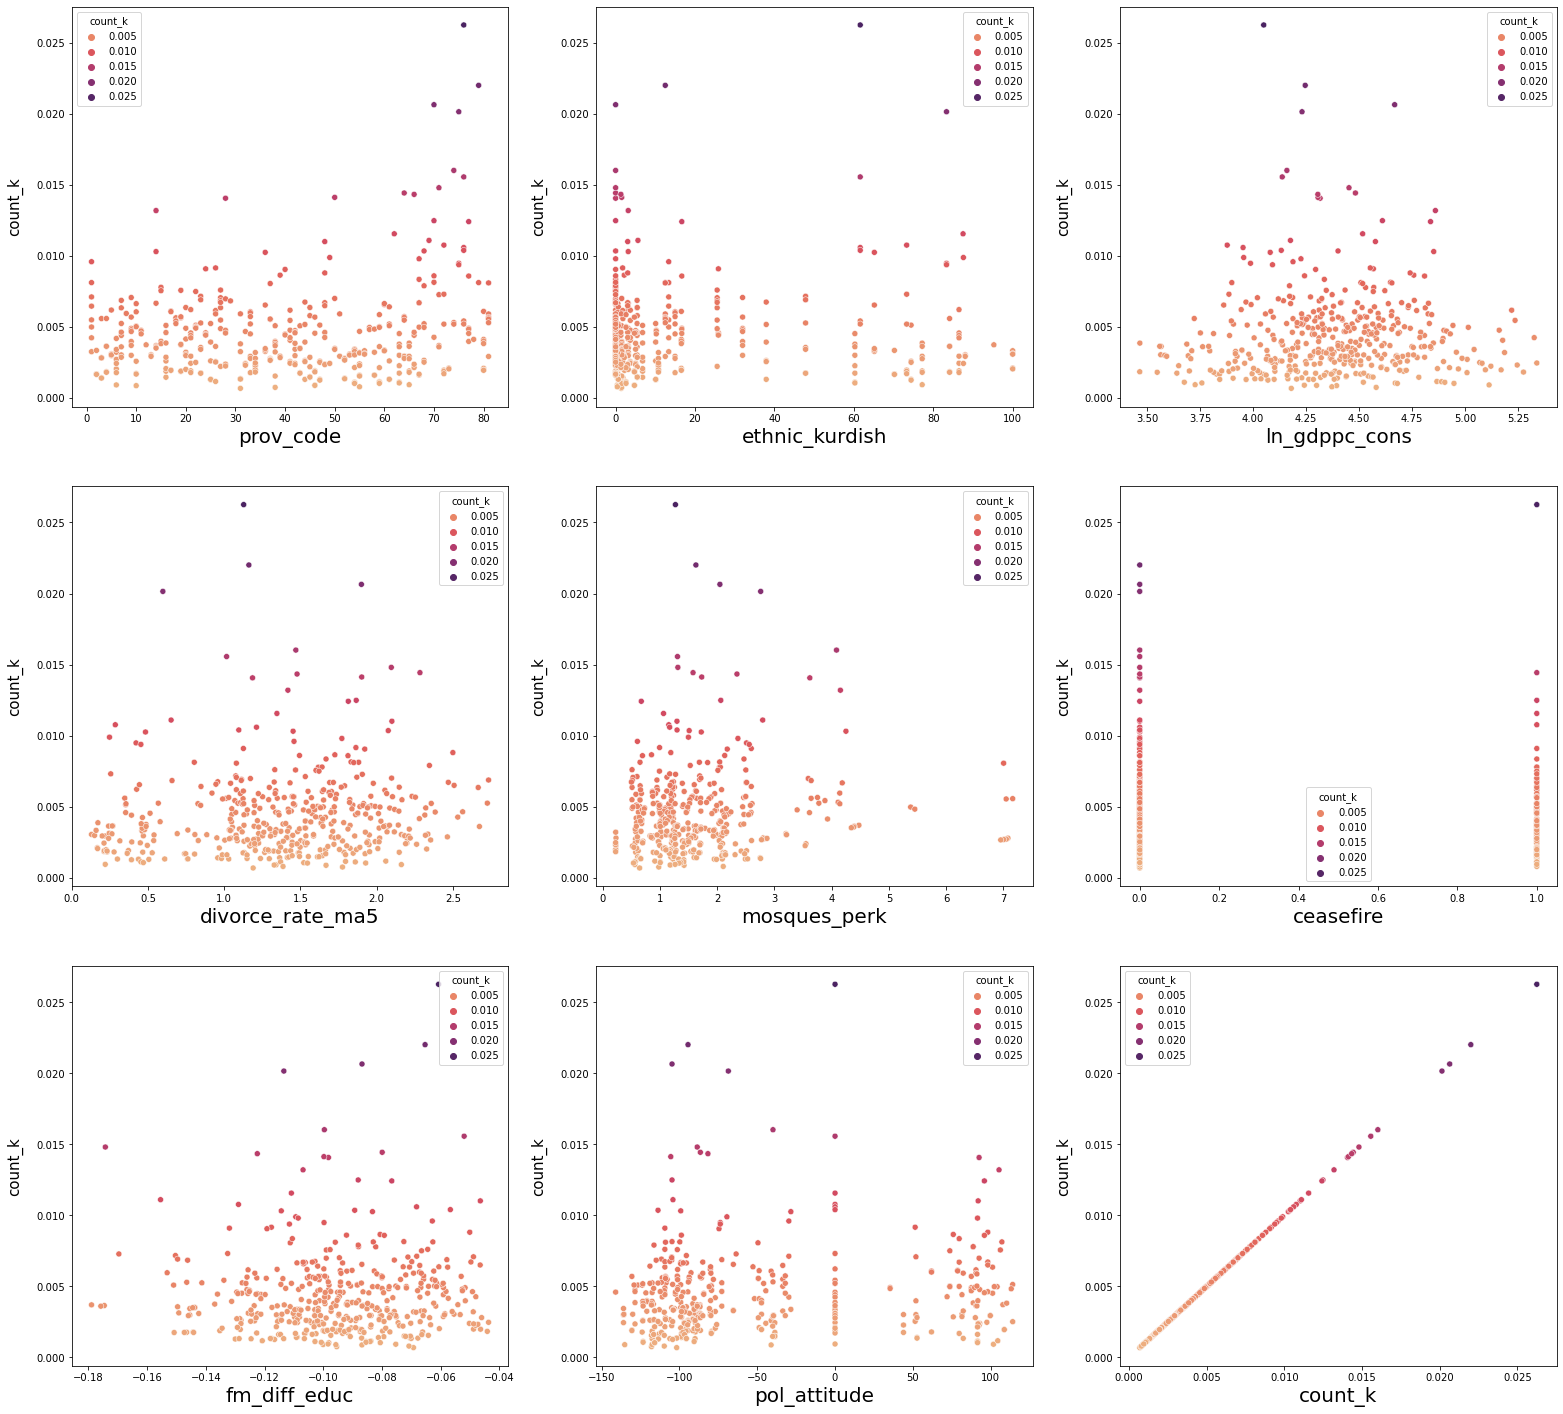

In [62]:
sns.color_palette("coolwarm", as_cmap=True)
fig,axs = plt.subplots(ncols=3, nrows=4, figsize =(15, 25))
plt.subplots_adjust(right=1.5)

for i, feature in enumerate(num, 1):    
    plt.subplot(3, 3, i)
    sns.scatterplot(x=feature, y='count_k', hue='count_k', palette = 'flare', data=num)
    plt.xlabel('{}'.format(feature), size=20)
    plt.ylabel('count_k', size=15, labelpad=12.5)
plt.show()

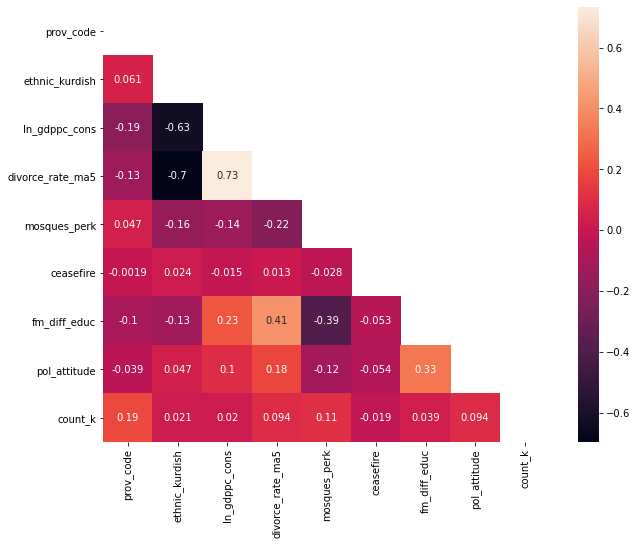

In [63]:
correlations_matrix = num.corr()
mask = np.zeros_like(correlations_matrix)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(correlations_matrix, mask=mask, annot=True)
plt.show()

In [64]:
num['count_k'].describe()

count    438.000000
mean       0.004465
std        0.003152
min        0.000678
25%        0.002471
50%        0.003683
75%        0.005546
max        0.026257
Name: count_k, dtype: float64

#### Some considerations:
-Ceasefire seems to have cases being equally present in the yes or no cases, we drop it.
-At the moment, GDP seems to show a higher presence of cases towards the middle. An Hypothesis could be that in lower GDP regions, some cases are not reported or added to the database. While in higher GDP regions, cases are more rare. We keep the column.
- We can notice some trends in relation to the Kurdish population. Lower the population percentage, the higher the cases. This could also be because of the correlation (previously seen) of the regions with kurdish pop. and the # of casualty. In war areas, cases of femicides may not be categorized as such.

In [65]:
num = num.drop('ceasefire', axis=1)

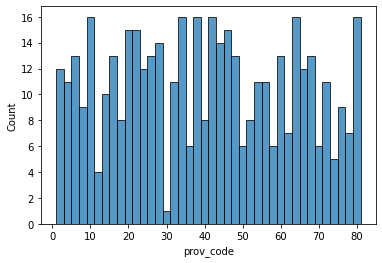

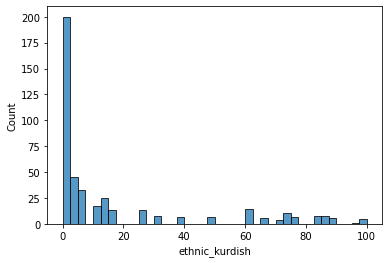

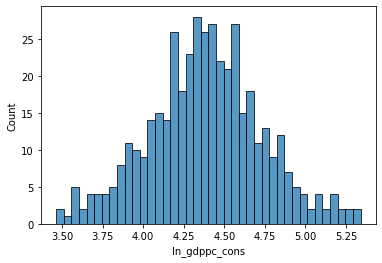

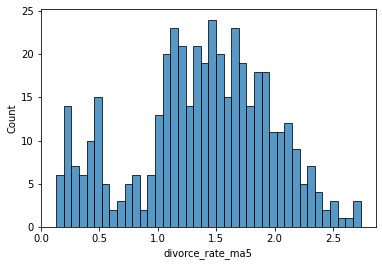

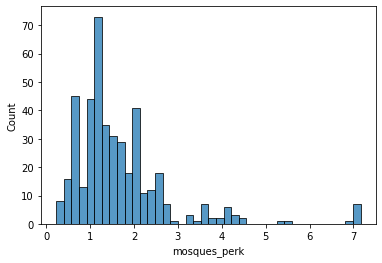

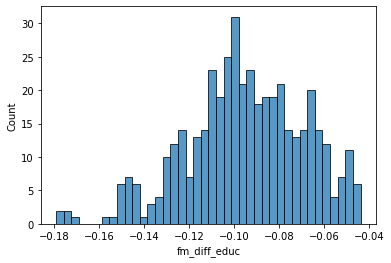

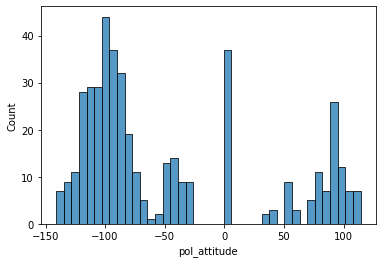

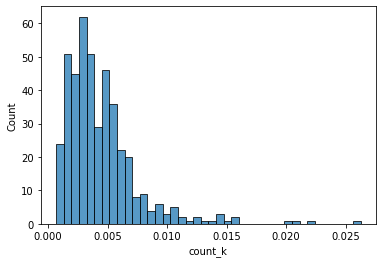

In [66]:
for i in range(num.shape[1]):
    sns.histplot(num[num.columns[i]], palette='flare', bins=40)
    plt.show()

In [67]:
num

,prov_code,ethnic_kurdish,ln_gdppc_cons,divorce_rate_ma5,mosques_perk,fm_diff_educ,pol_attitude,count_k
0,1,13.370917,4.187798,1.458,0.606649,-0.062882,-29.70,0.009591
1,1,13.370917,4.270533,1.532,0.599866,-0.068188,-29.70,0.007113
2,1,13.370917,4.310695,1.632,0.640750,-0.067100,-29.70,0.004234
3,1,13.370917,4.350712,1.712,0.651852,-0.066711,-33.60,0.003257
4,1,13.370917,4.379060,1.790,0.654324,-0.067147,-33.60,0.006465
...,...,...,...,...,...,...,...,...
433,81,12.500000,4.536124,1.454,1.894688,-0.104740,-109.00,0.005690
434,81,12.500000,4.592223,1.572,1.881597,-0.103488,-109.00,0.005625
435,81,12.500000,4.680219,1.730,1.856333,-0.102752,-109.00,0.005550
436,81,12.500000,4.654947,1.850,1.833297,-0.095931,-109.00,0.008100


Test boxcox and log transformation

In [68]:
def log_transform_clean(x):
    if x>0:
        return np.log(x)
    else:
        return 0  

In [69]:
def transformations (data, name):

    data[name+"_sqrt"] = data[name]**(1/2)
    data[name+"_log"] = list(map(log_transform_clean, data[name]))

    if data[name].min() > 0:
        box_cox, lmbda = stats.boxcox(data[name])
        data[name+"_bc"]= box_cox

        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (20,15)) 
        plt.subplots_adjust(left=None, bottom=5, right=None, top=6, wspace=None, hspace=None) 
        sns.histplot(data[name], ax=ax1)
        sns.histplot(data[name+"_sqrt"], ax=ax2)
        sns.histplot(data[name+"_log"], ax=ax3)
        sns.histplot(data[name+"_bc"], ax=ax4)
    else:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20,5)) 
        plt.subplots_adjust(left=None, bottom=5, right=None, top=6, wspace=None, hspace=None) 
        sns.histplot(data[name], ax=ax1)
        sns.histplot(data[name+"_sqrt"], ax=ax2)
        sns.histplot(data[name+"_log"], ax=ax3)
    return data

In [70]:
#Checked political attitudes and education, and everything looked better without transformation

# 2. Remove outliers with z from target
- some outliers are present on the target variable count_k
- the other variables being counts as 'mosques' and gdp we assume to be right as not based on reportings.

In [71]:
num.shape

(438, 8)

In [72]:
z = np.abs(stats.zscore(num['count_k']))

In [73]:
num_without = num.drop(np.where(z > 3)[0])

In [74]:
num_without.shape

(427, 8)

In [75]:
num_without

,prov_code,ethnic_kurdish,ln_gdppc_cons,divorce_rate_ma5,mosques_perk,fm_diff_educ,pol_attitude,count_k
0,1,13.370917,4.187798,1.458,0.606649,-0.062882,-29.70,0.009591
1,1,13.370917,4.270533,1.532,0.599866,-0.068188,-29.70,0.007113
2,1,13.370917,4.310695,1.632,0.640750,-0.067100,-29.70,0.004234
3,1,13.370917,4.350712,1.712,0.651852,-0.066711,-33.60,0.003257
4,1,13.370917,4.379060,1.790,0.654324,-0.067147,-33.60,0.006465
...,...,...,...,...,...,...,...,...
433,81,12.500000,4.536124,1.454,1.894688,-0.104740,-109.00,0.005690
434,81,12.500000,4.592223,1.572,1.881597,-0.103488,-109.00,0.005625
435,81,12.500000,4.680219,1.730,1.856333,-0.102752,-109.00,0.005550
436,81,12.500000,4.654947,1.850,1.833297,-0.095931,-109.00,0.008100


In [76]:
num_without.to_csv('not_scaled.csv', index=False)

For now we will work on the set without outliers, in case the model requires, we will try to run also the one with outliers.

# 3. Scaling data region

In [77]:
y = pd.DataFrame(num_without["count_k"])
data_nums_x = num_without.drop('count_k', axis=1)

#### Standardscaler

In [78]:
#transformer = StandardScaler().fit(data_nums_x)
#transformed = transformer.transform(data_nums_x)
#data_nums_x_sc = pd.DataFrame(transformed)
#data_nums_x_sc.columns = data_nums_x.columns

#### Normalizer

In [79]:
transformer = Normalizer().fit(data_nums_x)
transformed = transformer.transform(data_nums_x)
data_nums_x_no = pd.DataFrame(transformed)
data_nums_x_no.columns = data_nums_x.columns


In [80]:
list_titles = num_without.columns.values

Considerations: after checking the distribution. We will continue with the Normalizer results.

In [81]:
data_reg_preprocessed = pd.DataFrame(np.concatenate([data_nums_x_no,y], axis=1), columns = list_titles)

In [82]:
data_reg_preprocessed

,prov_code,ethnic_kurdish,ln_gdppc_cons,divorce_rate_ma5,mosques_perk,fm_diff_educ,pol_attitude,count_k
0,0.030402,0.406505,0.127318,0.044326,0.018443,-0.001912,-0.902945,0.009591
1,0.030389,0.406334,0.129779,0.046557,0.018230,-0.002072,-0.902564,0.007113
2,0.030379,0.406200,0.130956,0.049579,0.019466,-0.002038,-0.902268,0.004234
3,0.027410,0.366494,0.119252,0.046926,0.017867,-0.001829,-0.920970,0.003257
4,0.027404,0.366422,0.120006,0.049054,0.017931,-0.001840,-0.920788,0.006465
...,...,...,...,...,...,...,...,...
422,0.593529,0.091594,0.033239,0.010654,0.013883,-0.000767,-0.798700,0.005690
423,0.593516,0.091592,0.033649,0.011519,0.013787,-0.000758,-0.798682,0.005625
424,0.593497,0.091589,0.034293,0.012676,0.013602,-0.000753,-0.798656,0.005550
425,0.593495,0.091589,0.034107,0.013555,0.013433,-0.000703,-0.798654,0.008100


In [83]:
data_reg_preprocessed.to_csv('data_reg_preprocessed.csv', index=False)